В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Загружаем дата сет 
from sklearn.model_selection import train_test_split
url = 'https://raw.githubusercontent.com/george007361/ML_HW2/master/weather.csv'
X = pd.read_csv(url)
X.shape

(142193, 24)

In [3]:
#  смотрим сколько строк имеют пустые значения
print('All rows {0}'.format(len(X)))
print ('Rows has NaN {0}'.format(len(X.dropna(how='any'))))

All rows 142193
Rows has NaN 56420


In [4]:
# В каких колонках и сколько нанов
print("Cols has NaN:\n\n", X.apply(lambda a: sum(a.isnull()), axis=0))

Cols has NaN:

 Unnamed: 0           0
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64


In [5]:
# Удаляем колонки где много нанов, ненужные тоже удаляем
del X['Unnamed: 0']
del X['Sunshine']
del X['Evaporation']
del X['Cloud3pm']

In [6]:
# Меняем строковые булевые на численные
X = X[:].replace({'No': 0, 'Yes': 1, 'False' : 0, 'True': 1})


In [7]:
# Удалям строки, где много nan
X.drop(index = X[X.isna().sum(axis=1) >= 7].index, axis=1, inplace=True)

In [8]:
# Отделяем то, что хотим предсказать
y = X['RainTomorrow']
del X['RainTomorrow']

In [9]:
#  Делим дата сет на количественный и качественный
numeric_data = X.select_dtypes(include=[np.number])
categorical_data = X.select_dtypes(exclude=[np.number])

In [10]:
# Выделяем тестовые и тренеровочные данные
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 5)

In [11]:
# Выделяем колонки с количественными данными
numeric_columns = numeric_data.columns
# Заменяем наны в количественных на среднее
numeric_data_mean = numeric_data.mean()
X_train[numeric_columns] = X_train[numeric_columns].fillna(numeric_data_mean)
X_test[numeric_columns] = X_test[numeric_columns].fillna(numeric_data_mean)

In [12]:
# Заменяем наны в категориальных на NotGiven \
categorical_columns = categorical_data.columns
X_train[categorical_columns] = X_train[categorical_columns].fillna("NotGiven")
X_test[categorical_columns] = X_test[categorical_columns].fillna("NotGiven")

In [13]:
# Смотрим все ли наны ушли
print("Cols has NaN:\n\n", X_train.apply(lambda a: sum(a.isnull()), axis=0))

Cols has NaN:

 Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64


<IPython.core.display.Javascript object>


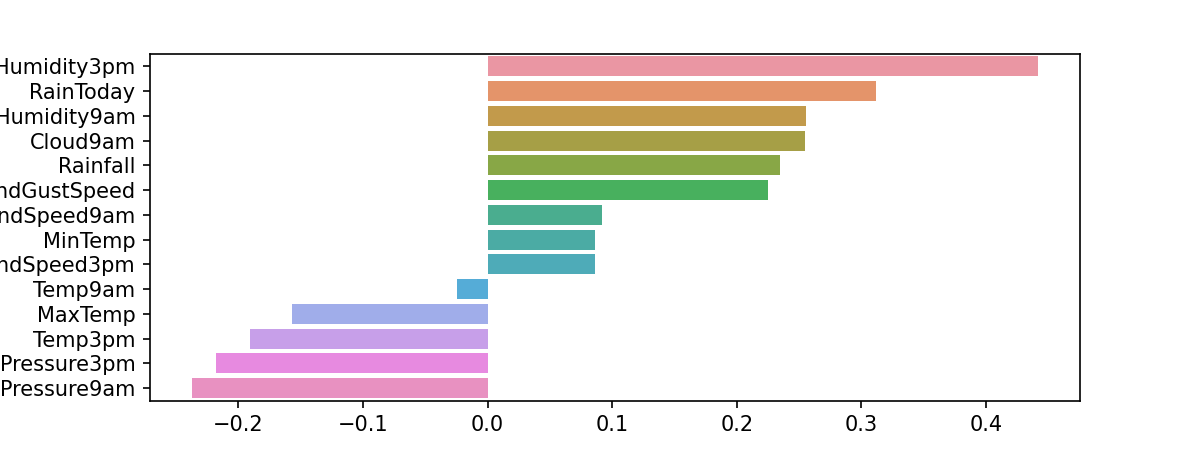

In [14]:
# Кореляции
correlations = X_train[numeric_columns].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(8, 3)
plt.show()

<IPython.core.display.Javascript object>


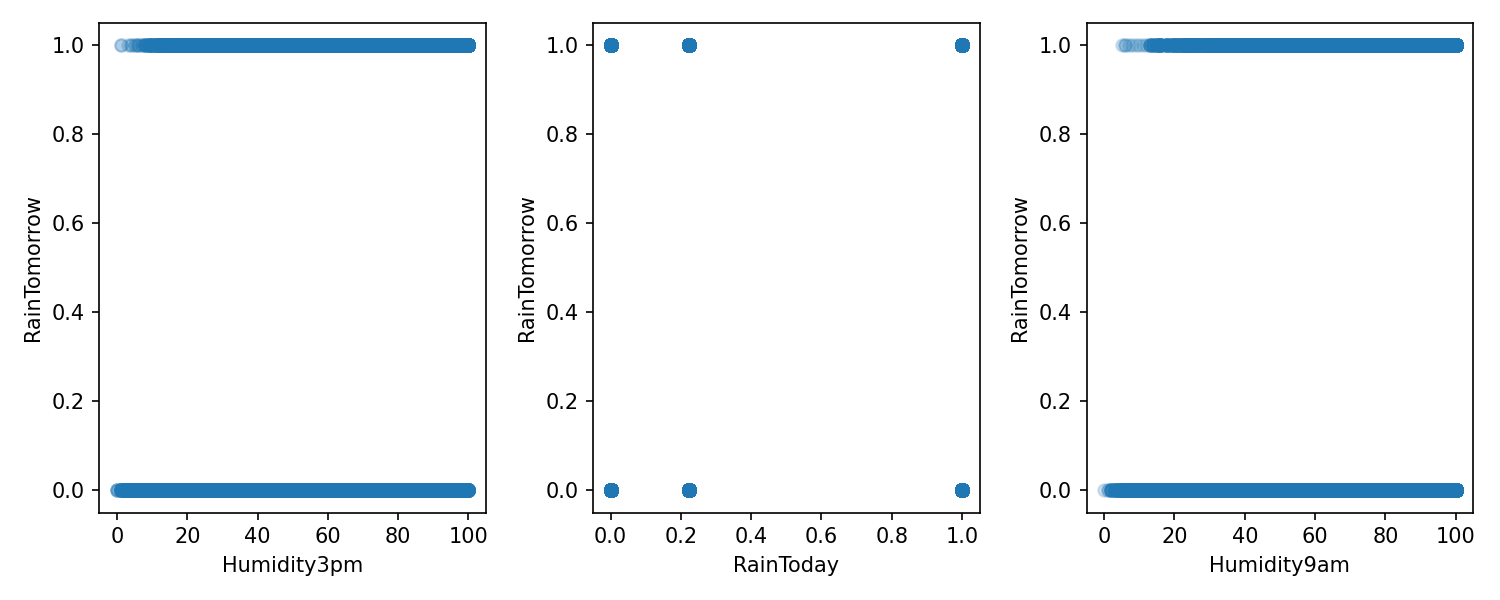

In [15]:
# ................
fig, axs = plt.subplots(figsize=(10 , 4), ncols=3)
for i, feature in enumerate(["Humidity3pm", "RainToday", "Humidity9am"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("RainTomorrow")
plt.tight_layout()

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [16]:
# Обучение на подготовленной выборке 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = LogisticRegression()
model.fit(X_train[numeric_columns], y_train)
y_pred = model.predict(X_test[numeric_columns])
y_train_pred = model.predict(X_train[numeric_columns])

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))

Test MAE = 0.1628
Train MAE = 0.1609


In [17]:
#  Cross val 
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_columns], y_train, cv=5, scoring="neg_mean_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MAE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.1630
	-0.1589
	-0.1620
	-0.1604
	-0.1615
Mean CV MAE = 0.1612


<IPython.core.display.Javascript object>


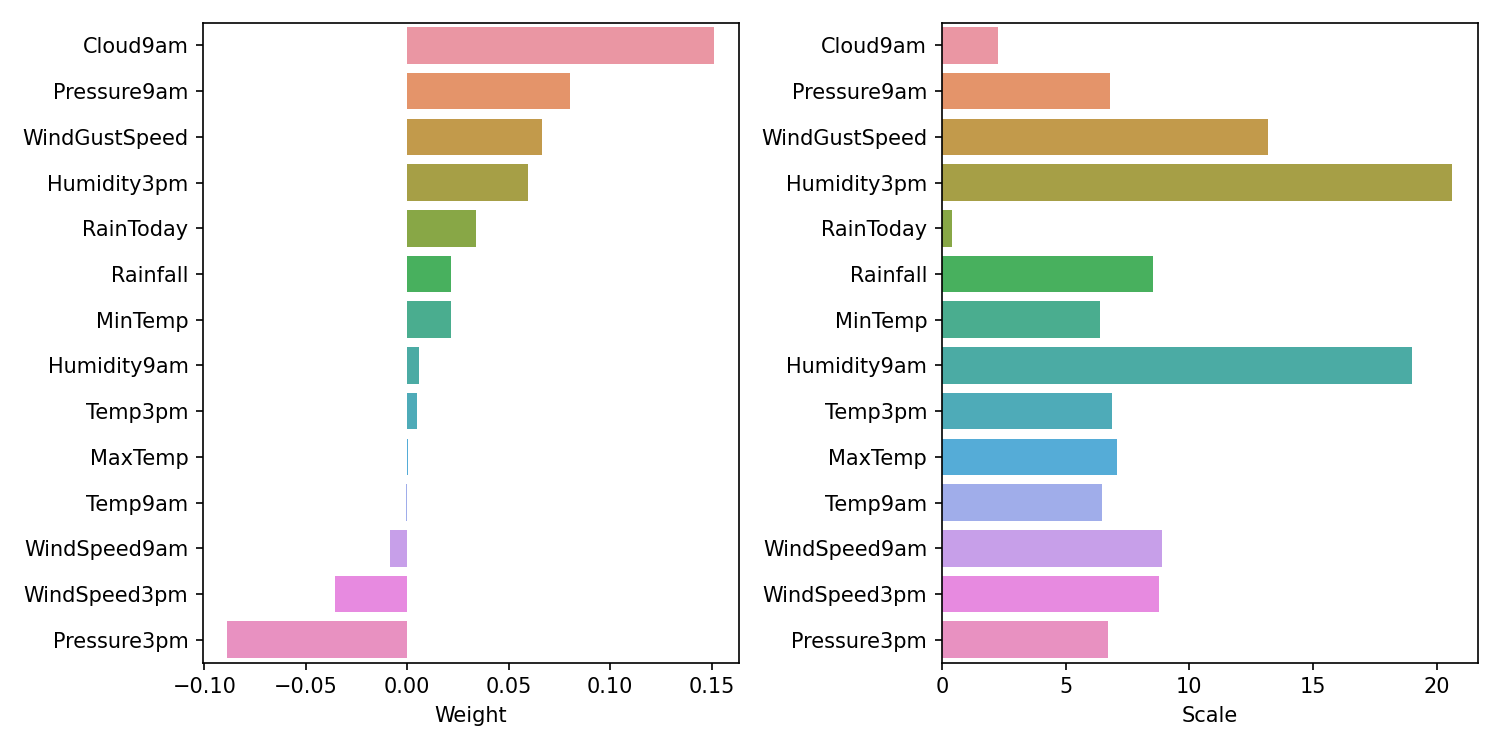

In [18]:
# Если очень хочется увидеть много цифр (веса)
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
#     print([x[1] for x in sorted_weights])
#     print(sorted_weights)
#     print(weights)
#     print(features)
#     print(scales)
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()
    
    
    
# Не совсем понял, почему coef_.shape стал (1, 14), хотя в примере он (14, )
show_weights(numeric_columns, model.coef_[0], X_train[numeric_columns].std())

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))

Test MAE = 0.1592
Train MAE = 0.1586


<IPython.core.display.Javascript object>


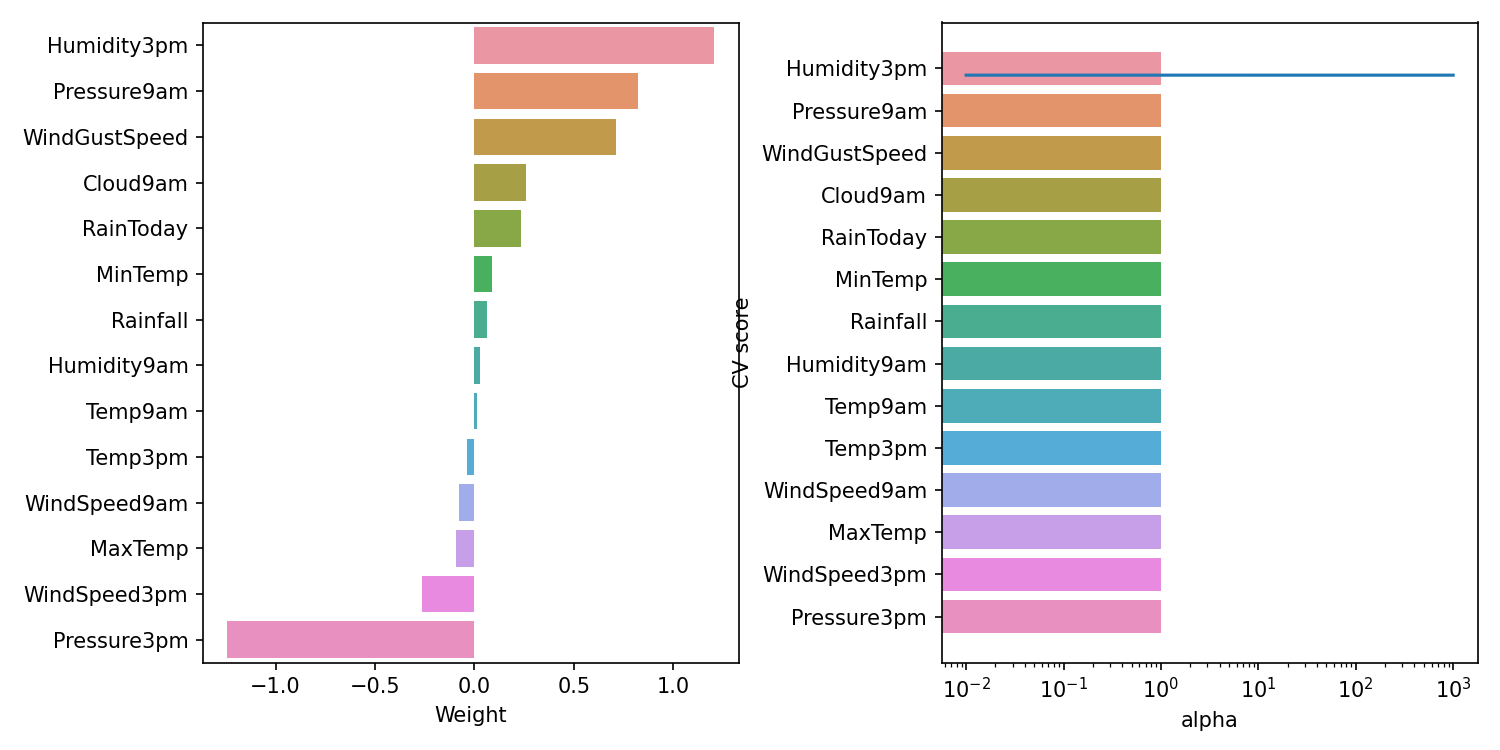

In [20]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_columns)


# Не совсем понял, почему coef_.shape стал (1, 14), хотя в примере он (14, )
show_weights(numeric_columns, model.coef_[0], scales)

In [21]:

from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(LogisticRegression(), [{"C":alphas}], scoring="neg_mean_absolute_error", cv=2, n_jobs=-1)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["C"]
# print("Best alpha = %.4f" % best_alpha)
# plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
# plt.xlabel("alpha")
# plt.ylabel("CV score")
# plt.show()

In [23]:
print("Best alpha = %.4f" % best_alpha)
# sns.barplot(y = alphas, x = -searcher.cv_results_["mean_test_score"])
# plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
# plt.xlabel("alpha")
# plt.ylabel("CV score")
# plt.show()
# plt.show()

Best alpha = 0.0183


In [24]:
from sklearn.pipeline import Pipeline
pipel = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', LogisticRegression(C=best_alpha))
])

model = pipel.fit(X_train[numeric_columns], y_train)
y_pred = model.predict(X_test[numeric_columns])
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 0.1600


In [27]:
X_train[categorical_columns].sample()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm
124192,2009-12-19,Walpole,ESE,E,SE


In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_data),
    ('scaling', StandardScaler(), numeric_columns)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [34]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (104989, 19)


AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [ ]:
def probability(theta, X):
    # YOUR CODE HERE
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

NameError: ignored

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    # YOUR CODE HERE
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [ ]:
def logloss(theta, X, y): 
    # YOUR CODE HERE
    return result

In [ ]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [ ]:
def gradient(theta, X, y):
    # YOUR CODE HERE
    
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [ ]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [ ]:
X, y = make_classification(n_samples=2000)

In [ ]:
optimal_theta = fit(X, y)

In [ ]:
y_pred = binary_class_prediction(optimal_theta, X)